# • R's Fable/HTS Replication1

<a href="https://colab.research.google.com/github/Nixtla/hierarchicalforecast/blob/main/nbs/examples/AustralianDomesticTourism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In many cases, only the time series at the lowest level of the hierarchies (bottom time series) are available. `HierarchicalForecast` has tools to create time series for all hierarchies. In this notebook we will see how to do it.

In [46]:

# compute base forecast no coherent
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, Naive
import pandas as pd

#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut
from datasetsforecast.hierarchical import HierarchicalData
import numpy as np
from statsforecast.models import ETS


## Aggregate bottom time series

In this example we will use the [Tourism](https://otexts.com/fpp3/tourism.html) dataset from the [Forecasting: Principles and Practice](https://otexts.com/fpp3/) book. The dataset only contains the time series at the lowest level, so we need to create the time series for all hierarchies.

In [47]:
# Load TourismSmall dataset
Y_df, S, tags = HierarchicalData.load('./data', 'TourismSmall')
Y_df['ds'] = pd.to_datetime(Y_df['ds'])

In [48]:
Y_df

,unique_id,ds,y
0,total,1998-03-31,84503
1,total,1998-06-30,65312
2,total,1998-09-30,72753
3,total,1998-12-31,70880
4,total,1999-03-31,86893
...,...,...,...
3199,nt-oth-noncity,2005-12-31,59
3200,nt-oth-noncity,2006-03-31,25
3201,nt-oth-noncity,2006-06-30,52
3202,nt-oth-noncity,2006-09-30,72


In [49]:
S

,nsw-hol-city,nsw-hol-noncity,vic-hol-city,vic-hol-noncity,qld-hol-city,qld-hol-noncity,sa-hol-city,sa-hol-noncity,wa-hol-city,wa-hol-noncity,...,qld-oth-city,qld-oth-noncity,sa-oth-city,sa-oth-noncity,wa-oth-city,wa-oth-noncity,tas-oth-city,tas-oth-noncity,nt-oth-city,nt-oth-noncity
total,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
hol,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
vfr,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
bus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
oth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wa-oth-noncity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
tas-oth-city,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
tas-oth-noncity,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
nt-oth-city,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [50]:
tags

{'Country': array(['total'], dtype=object),
 'Country/Purpose': array(['hol', 'vfr', 'bus', 'oth'], dtype=object),
 'Country/Purpose/State': array(['nsw-hol', 'vic-hol', 'qld-hol', 'sa-hol', 'wa-hol', 'tas-hol',
        'nt-hol', 'nsw-vfr', 'vic-vfr', 'qld-vfr', 'sa-vfr', 'wa-vfr',
        'tas-vfr', 'nt-vfr', 'nsw-bus', 'vic-bus', 'qld-bus', 'sa-bus',
        'wa-bus', 'tas-bus', 'nt-bus', 'nsw-oth', 'vic-oth', 'qld-oth',
        'sa-oth', 'wa-oth', 'tas-oth', 'nt-oth'], dtype=object),
 'Country/Purpose/State/CityNonCity': array(['nsw-hol-city', 'nsw-hol-noncity', 'vic-hol-city',
        'vic-hol-noncity', 'qld-hol-city', 'qld-hol-noncity',
        'sa-hol-city', 'sa-hol-noncity', 'wa-hol-city', 'wa-hol-noncity',
        'tas-hol-city', 'tas-hol-noncity', 'nt-hol-city', 'nt-hol-noncity',
        'nsw-vfr-city', 'nsw-vfr-noncity', 'vic-vfr-city',
        'vic-vfr-noncity', 'qld-vfr-city', 'qld-vfr-noncity',
        'sa-vfr-city', 'sa-vfr-noncity', 'wa-vfr-city', 'wa-vfr-noncity',
     

### Split Train/Test sets

We use the final horizon as test set.

In [51]:
HORIZON = 8

In [52]:
Y_test_df = Y_df.groupby('unique_id').tail(HORIZON)
Y_train_df = Y_df.drop(Y_test_df.index)

In [53]:
Y_test_df = Y_test_df.set_index('unique_id')
Y_train_df = Y_train_df.set_index('unique_id')

In [54]:
Y_train_df.groupby('unique_id').size()

unique_id
bus                28
hol                28
nsw-bus            28
nsw-bus-city       28
nsw-bus-noncity    28
                   ..
wa-oth-city        28
wa-oth-noncity     28
wa-vfr             28
wa-vfr-city        28
wa-vfr-noncity     28
Length: 89, dtype: int64

## Computing base forecasts

The following cell computes the **base forecasts** for each time series in `Y_df` using the `auto_arima` and `naive` models. Observe that `Y_hat_df` contains the forecasts but they are not coherent.

In [55]:
# Convert train df to gluonts format
# from data_utils import convert_df_to_gluonts_iter

from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

def convert_df_to_gluonts_iter(df: pd.DataFrame, horizon: int, frequency: str):

    unq_ids = np.unique(df.index)

    all_ts = []
    for id_ in unq_ids:
        df_one_ts = df[df.index == id_].sort_values("ds")
        start_time = df_one_ts["ds"][0]
        target_vals = df_one_ts["y"].values
        # print(id_, start_time, target_vals)
        all_ts.append(
            {
                FieldName.TARGET: target_vals,
                FieldName.START: start_time,
                FieldName.ITEM_ID: id_
            }
        )
    return ListDataset(all_ts, freq=frequency)

gluon_dset_train = convert_df_to_gluonts_iter(Y_train_df, HORIZON, "1Q")
gluon_dset_test = convert_df_to_gluonts_iter(Y_df.set_index('unique_id'), HORIZON, "1Q")

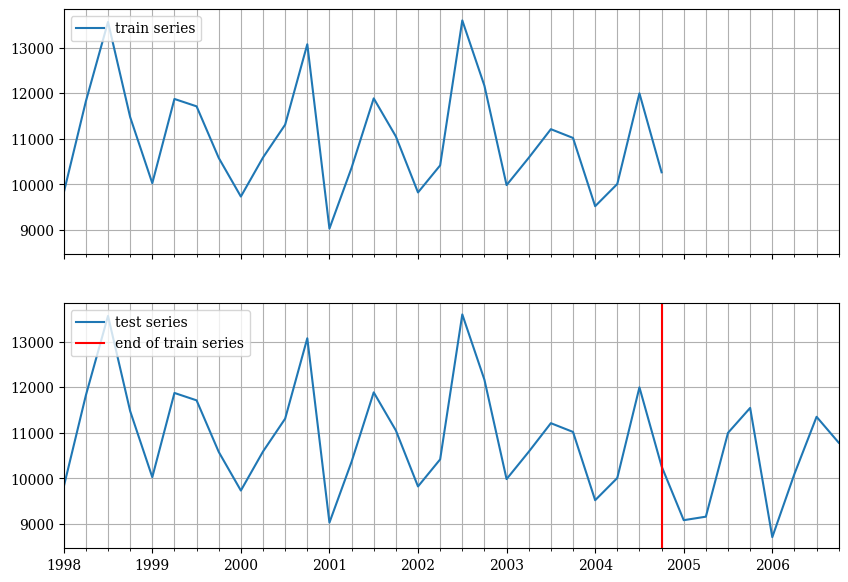

In [56]:
import matplotlib.pyplot as plt
from gluonts.dataset.util import to_pandas

train_entry = next(iter(gluon_dset_train))
test_entry = next(iter(gluon_dset_test))

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color="r")  # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()



In [57]:

from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer

EPOCHS = 10
FREQ = "1Q"
LR = 1e-3
BATCHES_PER_EPOCH = 100

# Get best model params from HPO
CONTEXT_LEN = 2*HORIZON
# num_layers = 2
# dropout_rate = 0.4
# EPOCHS = 25
# num_cells = 40

estimator = DeepAREstimator(
    freq=FREQ,
    prediction_length=HORIZON,
    trainer=Trainer(ctx="cpu", epochs=EPOCHS, learning_rate=1e-3, num_batches_per_epoch=BATCHES_PER_EPOCH),
    context_length=CONTEXT_LEN,
    scaling=True,
    # num_layers=num_layers,
    # num_cells=num_cells, 
    # dropout_rate=dropout_rate
)

predictor = estimator.train(gluon_dset_train)

# # Fit and predict with N-BEATS and N-HiTS models
# models = [NBEATS(input_size=CONTEXT_LEN, h=HORIZON, max_epochs=EPOCHS)]
# fcst = NeuralForecast(models=models, freq='M')
# fcst.fit(df=Y_train_df)

INFO:gluonts.trainer:Start model training
INFO:gluonts.trainer:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.65it/s, epoch=1/10, avg_epoch_loss=7.57]
INFO:gluonts.trainer:Epoch[0] Elapsed time 15.054 seconds
INFO:gluonts.trainer:Epoch[0] Evaluation metric 'epoch_loss'=7.573779
INFO:gluonts.trainer:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.40it/s, epoch=2/10, avg_epoch_loss=7.32]
INFO:gluonts.trainer:Epoch[1] Elapsed time 15.627 seconds
INFO:gluonts.trainer:Epoch[1] Evaluation metric 'epoch_loss'=7.317616
INFO:gluonts.trainer:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.54it/s, epoch=3/10, avg_epoch_loss=7.23]
INFO:gluonts.trainer:Epoch[2] Elapsed time 15.286 seconds
INFO:gluonts.trainer:Epoch[2] Evaluation metric 'epoch_loss'=7.234791
INFO:gluonts.trainer:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.31it/s, epoch=4/10, avg_epoch_loss=7.22]
INFO:gluonts.trainer:Epoch[3] 

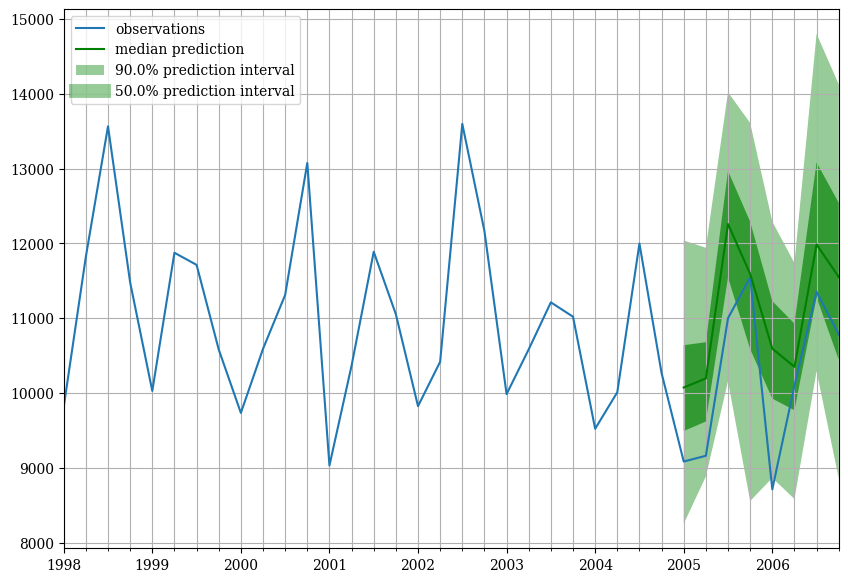

In [58]:
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=gluon_dset_test,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]
plot_prob_forecasts(ts_entry, forecast_entry)

### Convert the forecasts iterator into pandas df

In [59]:
def convert_gluonts_iter_to_df(
    gluon_iter,
    test_dates
):
    out = []
    dates = []
    ids = []
    for x in gluon_iter:
        ids.extend([x.item_id]*HORIZON)
        out.extend(np.mean(x.samples, axis=0).reshape(-1))
        dates.extend(test_dates)
    out = pd.DataFrame({"unique_id": ids, "ds": dates, "y_hat": out})
    out = out.set_index("unique_id")
    return out

test_dates = Y_test_df["ds"].unique()
test_dates.sort()
forecast_df = convert_gluonts_iter_to_df(forecasts, test_dates)
print(forecast_df)

                       ds         y_hat
unique_id                              
bus            2005-03-31  10082.287109
bus            2005-06-30  10211.293945
bus            2005-09-30  12196.800781
bus            2005-12-31  11401.931641
bus            2006-03-31  10551.383789
...                   ...           ...
wa-vfr-noncity 2005-12-31    977.418030
wa-vfr-noncity 2006-03-31    954.539062
wa-vfr-noncity 2006-06-30    816.352173
wa-vfr-noncity 2006-09-30    973.397217
wa-vfr-noncity 2006-12-31   1053.795410

[712 rows x 2 columns]


### Computing in-sample forecasts needed for MinT, ERM methods
Note that the model is already trained on the training part of the data. Now, the in-sample forecasts are obtained by a moving window method. These in-sample forecasts are needed to estimate the residual covariance matrix in MinT and ERM methods.

In [60]:
dates = Y_df.ds.unique()
dates.sort()
dates_train = Y_train_df.ds.unique()
dates_train.sort()
Y_hat_in_sample = None
for i in range(0, len(dates_train)-HORIZON-CONTEXT_LEN+1):
    # print(i, i+CONTEXT_LEN, i+CONTEXT_LEN+HORIZON)
    backtest_history = Y_train_df[(Y_train_df.ds >= dates[i]) & (Y_train_df.ds < dates[i+CONTEXT_LEN])]
    end_pt = i+CONTEXT_LEN+HORIZON
    if end_pt < len(dates_train):
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN]) & (Y_train_df.ds < dates[end_pt])]
    else:
        backtest_test_true = Y_train_df[(Y_train_df.ds >= dates[i+CONTEXT_LEN])]
    # print(len(backtest_test_true))
    backtest_history_iter = convert_df_to_gluonts_iter(backtest_history, HORIZON, "1Q")
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=backtest_history_iter,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=100,  # number of sample paths we want for evaluation
                        )
    forecasts = list(forecast_it)
    # Y_hat_in_sample_part = fcst.predict(df=backtest_history)
    test_dates = backtest_test_true["ds"].unique()
    test_dates.sort()
    Y_hat_in_sample_part = convert_gluonts_iter_to_df(forecasts, test_dates)
    # Y_hat_in_sample_part["ds"] = backtest_test_true["ds"].values
    first_horizon_date = backtest_test_true["ds"].unique()[0]
    if Y_hat_in_sample is None:
        Y_hat_in_sample = Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]
    else:
        if i == len(dates_train)-HORIZON-CONTEXT_LEN:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part])
        else:
            Y_hat_in_sample = pd.concat([Y_hat_in_sample, Y_hat_in_sample_part[Y_hat_in_sample_part["ds"] == first_horizon_date]])

In [61]:
Y_hat_in_sample_part

,ds,y_hat
unique_id,,
bus,2003-03-31,11406.218750
bus,2003-06-30,10661.687500
bus,2003-09-30,11268.267578
bus,2003-12-31,12210.673828
bus,2004-03-31,10861.653320
...,...,...
wa-vfr-noncity,2003-12-31,897.549866
wa-vfr-noncity,2004-03-31,755.062683
wa-vfr-noncity,2004-06-30,756.481567


## Predict on test

In [62]:
Y_hat_df = forecast_df
Y_hat_df

,ds,y_hat
unique_id,,
bus,2005-03-31,10082.287109
bus,2005-06-30,10211.293945
bus,2005-09-30,12196.800781
bus,2005-12-31,11401.931641
bus,2006-03-31,10551.383789
...,...,...
wa-vfr-noncity,2005-12-31,977.418030
wa-vfr-noncity,2006-03-31,954.539062
wa-vfr-noncity,2006-06-30,816.352173


In [63]:
# Create Y_df with y_hat_in_sample
Y_train_df_extended = Y_train_df.merge(Y_hat_in_sample, on=["ds", "unique_id"], how="inner")
Y_train_df_extended

,ds,y,y_hat
unique_id,,,
total,2002-03-31,83938,89901.726562
total,2002-06-30,63529,75009.718750
total,2002-09-30,75540,81758.117188
total,2002-12-31,75663,84853.507812
total,2003-03-31,83860,90191.742188
...,...,...,...
nt-oth-noncity,2003-12-31,132,172.436935
nt-oth-noncity,2004-03-31,12,67.385002
nt-oth-noncity,2004-06-30,40,80.143837


## Reconcile forecasts

The following cell makes the previous forecasts coherent using the `HierarchicalReconciliation` class. Since the hierarchy structure is not strict, we can't use methods such as `TopDown` or `MiddleOut`. In this example we use `BottomUp` and `MinTrace`.

In [64]:
from hierarchicalforecast.methods import BottomUp, MinTrace, ERM

reconcilers = [
    BottomUp(),
    MinTrace(method='mint_shrink'),
    MinTrace(method='ols'),
    ERM(method='reg')
]
hrec = HierarchicalReconciliation(reconcilers=reconcilers)
Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_train_df_extended, S=S, tags=tags)

The dataframe `Y_rec_df` contains the reconciled forecasts.

In [65]:
Y_rec_df

,ds,y_hat,y_hat/BottomUp,y_hat/MinTrace_method-mint_shrink,y_hat/MinTrace_method-ols,y_hat/ERM_method-reg_lambda_reg-0.01
unique_id,,,,,,
total,2005-03-31,88017.359375,85804.578125,86459.641841,87632.777516,88331.687500
total,2005-06-30,67519.125000,67804.671875,67671.600896,67471.735430,62915.097656
total,2005-09-30,74176.664062,73275.867188,73668.264646,74131.705067,60116.246094
total,2005-12-31,76050.656250,77716.148438,76813.333207,75986.055245,68778.351562
total,2006-03-31,88777.632812,86811.226562,87141.177656,88339.041539,86785.039062
...,...,...,...,...,...,...
nt-oth-noncity,2005-12-31,149.375732,149.375732,154.821335,169.599850,-246.471619
nt-oth-noncity,2006-03-31,21.462269,21.462269,24.815253,52.535651,-208.234695
nt-oth-noncity,2006-06-30,61.673450,61.673450,58.763152,59.594316,-368.711670


## Evaluation 

The `HierarchicalForecast` package includes the `HierarchicalEvaluation` class to evaluate the different hierarchies and also is capable of compute scaled metrics compared to a benchmark model.

In [66]:
from hierarchicalforecast.evaluation import HierarchicalEvaluation

def rmse(y, y_hat):
    return np.mean(np.sqrt(np.mean((y-y_hat)**2, axis=1)))

def mase(y, y_hat, y_insample, seasonality=4):
    errors = np.mean(np.abs(y - y_hat), axis=1)
    scale = np.mean(np.abs(y_insample[:, seasonality:] - y_insample[:, :-seasonality]), axis=1)
    return np.mean(errors / scale)

def rmsse(y, y_hat, y_insample):
    errors = np.mean(np.square(y - y_hat), axis=1)
    scale = np.mean(np.square(y_insample[:, 1:] - y_insample[:, :-1]), axis=1)
    return np.mean(np.sqrt(errors / scale))

eval_tags = {}
eval_tags['Total'] = tags['Country']
eval_tags['Purpose'] = tags['Country/Purpose']
# eval_tags['State'] = tags['Country/State']#np.concatenate([val for key, val in tags.items() if 'State' in key])
# eval_tags['Regions'] = tags['Country/State/Region']
eval_tags['Purpose-State'] = tags['Country/Purpose/State']
# eval_tags['Bottom'] = tags['Country/State/Region/Purpose']
eval_tags['Regions'] = tags['Country/Purpose/State/CityNonCity']
# eval_tags['All'] = np.concatenate(list(tags.values()))

evaluator = HierarchicalEvaluation(evaluators=[rmse, mase, rmsse])
evaluation = evaluator.evaluate(
        Y_hat_df=Y_rec_df, Y_test_df=Y_test_df,
        tags=eval_tags, Y_df=Y_train_df
)
evaluation = evaluation.drop('Overall')
# evaluation.columns = ['Base', 'BottomUp', 'MinTrace(mint_shrink)', 'MinTrace(ols)']
evaluation.columns = ['Base', 'BottomUp', 'MinTrace(ols)', 'MinTrace(mint_shrink)', 'ERM']
evaluation = evaluation.applymap('{:.4f}'.format)

/tmp/ipykernel_2193670/3203693170.py:31: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  evaluation = evaluation.drop('Overall')


### RMSE

The following table shows the performance measured using RMSE across levels for each reconciliation method.

In [67]:
score_df = evaluation.query('metric == "rmse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Total,rmse,7566.1206,7635.0484,7408.2875,7447.5645,4205.3686
Purpose,rmse,2005.3270,2125.6587,2075.7444,2106.8515,3949.2048
Purpose-State,rmse,413.0880,420.3988,414.6964,417.9093,1033.6546
Regions,rmse,251.1692,251.1692,248.2195,250.3001,694.0784


### MASE


The following table shows the performance measured using MASE across levels for each reconciliation method.

In [68]:
evaluation.query('metric == "mase"')

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Total,mase,2.5052,2.3696,2.3388,2.4400,1.4869
Purpose,mase,1.3696,1.4656,1.4246,1.4796,3.3769
Purpose-State,mase,0.9786,0.9852,0.9750,0.9926,2.7950
Regions,mase,0.8920,0.8920,0.8826,0.9011,2.9848


### RMSSE

In [69]:
score_df = evaluation.query('metric == "rmsse"')
score_df

,,Base,BottomUp,MinTrace(ols),MinTrace(mint_shrink),ERM
level,metric,,,,,
Total,rmsse,0.6350,0.6408,0.6218,0.6251,0.3530
Purpose,rmsse,0.6155,0.6242,0.6197,0.6577,1.4160
Purpose-State,rmsse,0.5968,0.5965,0.5961,0.6206,1.6485
Regions,rmsse,0.6119,0.6119,0.6108,0.6273,1.8476


In [70]:
score_df.astype(float).mean()

Base                     0.614800
BottomUp                 0.618350
MinTrace(ols)            0.612100
MinTrace(mint_shrink)    0.632675
ERM                      1.316275
dtype: float64

### Comparison fable

Observe that we can recover the results reported by the [Forecasting: Principles and Practice](https://otexts.com/fpp3/tourism.html). The original results were calculated using the R package [fable](https://github.com/tidyverts/fable).

![Fable's reconciliation results](./imgs/AustralianDomesticTourism-results-fable.png)

### References
- [Hyndman, R.J., & Athanasopoulos, G. (2021). "Forecasting: principles and practice, 3rd edition: 
Chapter 11: Forecasting hierarchical and grouped series.". OTexts: Melbourne, Australia. OTexts.com/fpp3 
Accessed on July 2022.](https://otexts.com/fpp3/hierarchical.html)
- [Rob Hyndman, Alan Lee, Earo Wang, Shanika Wickramasuriya, and Maintainer Earo Wang (2021). "hts: Hierarchical and Grouped Time Series". URL https://CRAN.R-project.org/package=hts. R package version 0.3.1.](https://cran.r-project.org/web/packages/hts/index.html)
- [Mitchell O’Hara-Wild, Rob Hyndman, Earo Wang, Gabriel Caceres, Tim-Gunnar Hensel, and Timothy Hyndman (2021). "fable: Forecasting Models for Tidy Time Series". URL https://CRAN.R-project.org/package=fable. R package version 6.0.2.](https://CRAN.R-project.org/package=fable)